# **W1D1: Introduction to the Climate System and Xarray**

## Overview

In tutorials 4 to 9 of today, we will introduce various tools within [Xarray](https://xarray.dev/) to help us analyze and interpret climate data, such as sea surface temperature data. 

We'll cover these topics:

1. Arithmetic and Aggregation Methods
1. `groupby` operation to enable **split-apply-combine** workflow
1. `.weighted()` method
1. `resample`, `rolling`, and `coarsen` methods
1. Masking data using `xr.where()` or `.where()` method

# **Tutorial 5: Xarray Data Analysis and Climatology**

**Week 1, Day 1, Introduction to the Climate System**

**Content creators:** Sloane Garelick, Julia Kent

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Ohad Zivan

**Content editors:** Agustina Pesce

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS


### **Code and Data Sources**

Code and data for this tutorial is based on existing content from [Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html).

## **Tutorial Objectives**

Global climate can vary on long timescales, but it's also important to understand seasonal variations. For example, seasonal variations in precipitation associated with the migration of the ITCZ and monsoon systems occur in response to seasonal changes in temperature. In this tutorial, we will use data analysis tools in Xarray to explore seasonal climatology in global temperature and precipitation data. Specifically, in this tutorial, we'll use the `groupby` operation in Xarray, which involves the completing the following steps:

- **Split**: group data by value (e.g., month).
- **Apply**: compute some function (e.g., aggregate) within the individual groups.
- **Combine**: merge the results of these operations into an output dataset.

In [2]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# Setup


In [1]:
# !pip install matplotlib.pyplot
# !pip install numpy
# !pip install xarray
# !pip install pythia_datasets
# !pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pythia_datasets import DATASETS
import pandas as pd

In [4]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

ModuleNotFoundError: No module named 'ipywidgets'

Let's start by loading the same data that we used in the previous tutorial (monthly SST data from CESM2):

In [5]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
ds = xr.open_dataset(filepath,decode_times=False)
new_time = pd.date_range(start='2000-01-15', end='2014-12-15', periods=180)
ds = ds.assign(time=new_time)

# Section 1: GroupBy: Split, Apply, Combine

Simple aggregations (as we learned in the previous tutorial) can give useful summary of our dataset, but often we would prefer to aggregate conditionally on some coordinate labels or groups. Xarray provides the so-called `groupby` operation which enables the **split-apply-combine** workflow on Xarray DataArrays and Datasets. The split-apply-combine operation is illustrated in this figure

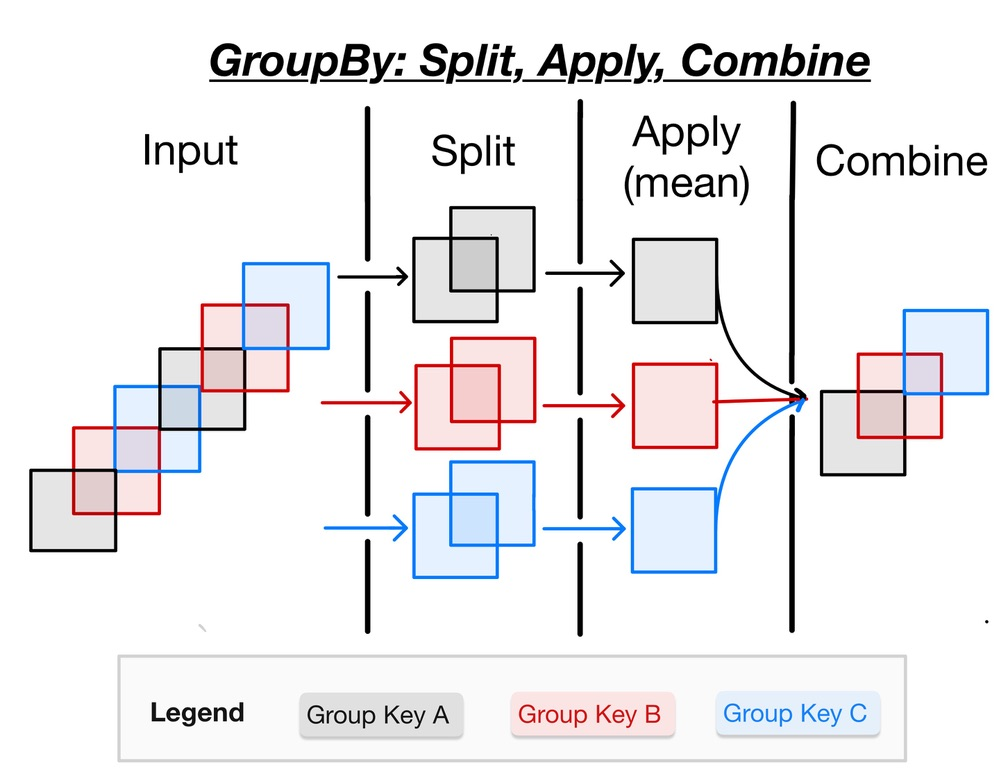



- The **split** step involves breaking up and grouping an xarray Dataset or DataArray depending on the value of the specified group key.
- The **apply** step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The **combine** step merges the results of these operations into an output xarray Dataset or DataArray.

We are going to use `groupby` to remove the seasonal cycle ("climatology") from our dataset, which will allow us to better observe long-term trends in the data. See the [xarray `groupby` user guide](https://xarray.pydata.org/en/stable/user-guide/groupby.html) for more examples of what `groupby` can take as an input.

First, let's select a gridpoint closest to a specified lat-lon (in this case let's select 50ºN, 310ºE), and plot a time series of SST at that point (recall that we learned this is Tutorial 2). The annual cycle will be quite evident.

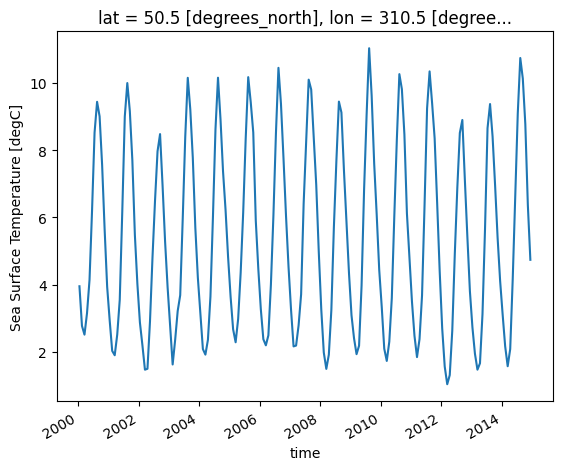

In [6]:
ds.tos.sel(lon=310, lat=50, method='nearest').plot(); #time range is 2000-01-15 to 2014-12-15

This plot is showing changes in monthly SST between 2000-01-15 to 2014-12-15. The annual cycle of SST change is apparent in this figure. But to understand the climatatology of this region, we need to calculate the average SST for each month over this time period. The first step is to split the data into groups based on month.

## Section 1.1: Split

Let's group data by month, i.e. all Januaries in one group, all Februaries in one group, etc.


In [7]:
ds.tos.groupby(ds.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

<div class="admonition alert alert-info">

In the above code, we are using the `.dt` [`DatetimeAccessor`](https://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html) to extract specific components of dates/times in our time coordinate dimension. For example, we can extract the year with `ds.time.dt.year`. See also the equivalent [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).
    
   </div>

Xarray also offers a more concise syntax when the variable you’re grouping on is already present in the dataset. This is identical to `ds.tos.groupby(ds.time.dt.month)`:

In [8]:
ds.tos.groupby('time.month')

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

## Section 1.2: Apply & Combine 

Now that we have groups defined, it’s time to “apply” a calculation to the group. These calculations can either be:

- aggregation: reduces the size of the group
- transformation: preserves the group’s full size

At then end of the apply step, xarray will automatically combine the aggregated/transformed groups back into a single object. 



### Section 1.2.1: Compute climatology 


Let's calculate the climatology at every point in the dataset. To do so we, will use aggregation and will calculate the mean SST for each month:


In [9]:
tos_clim = ds.tos.groupby('time.month').mean()
tos_clim

<xarray.DataArray 'tos' (month: 12, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.780786 , -1.780688 , -1.7805718, ..., -1.7809757,
         -1.7809197, -1.7808627],
        [-1.7745041, -1.7744204, -1.7743237, ..., -1.77467  ,
         -1.774626 , -1.7745715],
        [-1.7691481, -1.7690798, -1.7690051, ..., -1.7693441,
         -1.7692844, -1.7692182]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7605033, -1.760397 , -1.7602725, ..., -1.760718 ,
         -1.7606541, -1.7605885],
        [-1.7544289, -1.7543424, -1.7542422, ..., -1.754608 ,
         -1.754559 , -1.7545002],
        [-1.7492163, -1.749148 , -1.7490736, ..., -1.7494118,
         -1.7493519, -1.7492864]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7711828, -1.7710832, -1.7709653, ..., -1.7713748,
         -1.7713183, -1.7712607],
        [-1.7648666, -1.7647841, -1.7646879, ..., -1.7650299,
         -1.7649865, -1.7649331],
        [-1.759478 , -1.7594113, -1.7593384, ..., -1.7596704,
         -1.7596117, -1.759547 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

For every spatial coordinate, we now have a monthly mean SST for the time period 2000-01-15 to 2014-12-15.

We can now plot the climatology at a specific point:

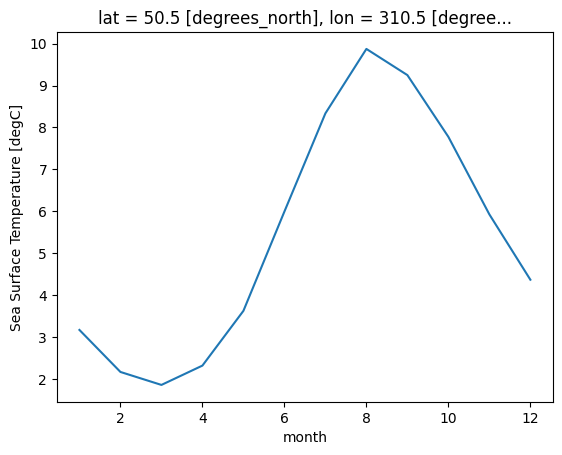

In [10]:
tos_clim.sel(lon=310, lat=50, method='nearest').plot();

Based on this plot, the climatology of this location is defined by cooler SST from December to April and warmer SST from June to October, with an annual SST range of ~8ºC. 
- Considering the latitude and longitude of this data, can you explain why we observe this climatology?
-  How do you think seasonal variations in SST would differ at the equator? What about at the poles? What about at 50ºS?

In [12]:
# to_remove explanation

"""
This location's strong seasonality suggests this is a location that experiences significant seasonal variation due to solar radiation received at the surface over the course of a year. Seasonal variations in sea surface temperature (SST) would differ at different latitudes. At the equator, the seasonal variations in SST tend to be relatively small. This is because the equatorial region experiences a relatively constant amount of solar radiation throughout the year, resulting in a relatively stable SST. At the poles, however, the seasonal variations in SST are more pronounced. At 50ºS, which is closer to the South Pole, the seasonal variations in SST would also be noticeable but less extreme compared to the polar regions.
"""

"\nThis location's strong seasonality suggests this is a location that experiences significant seasonal variation due to solar radiation received at the surface over the course of a year. Seasonal variations in sea surface temperature (SST) would differ at different latitudes. At the equator, the seasonal variations in SST tend to be relatively small. This is because the equatorial region experiences a relatively constant amount of solar radiation throughout the year, resulting in a relatively stable SST. At the poles, however, the seasonal variations in SST are more pronounced. At 50ºS, which is closer to the South Pole, the seasonal variations in SST would also be noticeable but less extreme compared to the polar regions.\n"

We can now add a spatial dimension to this plot and look at the zonal mean climatology (the monthly mean SST at different latitudes):

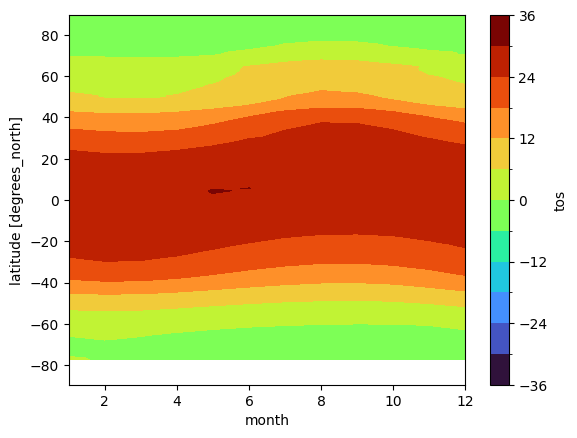

In [13]:
tos_clim.mean(dim='lon').transpose().plot.contourf(levels=12, cmap='turbo');

This gives us helpful information about the mean SST for each month, but it's difficult to asses the range of monthly temperatures throughout the year using this plot.

To better represent the range of SST, we can calculate and plot the difference between January and July climatologies:

In [ ]:
(tos_clim.sel(month=1) - tos_clim.sel(month=7)).plot(size=6, robust=True);

- What patterns do you observe in this map?
- Why is there such an apparent difference between the Northern and Southern Hemisphere SST changes?
- Based on this map, explain how and why the ITCZ migrates seasonally?

In [15]:
# to_remove explanation

"""
The asymmetry in sea surface temperature (SST) changes between the Northern and Southern Hemispheres can be attributed to several factors including more land coverage in the Northern Hemisphere, ocean currents and wind patterns.
The ITCZ shifts with the seasons. During the time when the Sun is directly overhead at the Norhtern Tropic (June), the ITCZ moves northwards, and when the Sun is directly overhead at the Sounthern Tropic (December), the ITCZ shifts southwards. This migration can affect the distribution of rain, leading to wet and dry seasons in many tropical regions.
"""

'\nThe asymmetry in sea surface temperature (SST) changes between the Northern and Southern Hemispheres can be attributed to several factors including more land coverage in the Northern Hemisphere, ocean currents and wind patterns.\nThe ITCZ shifts with the seasons. During the time when the Sun is directly overhead at the Norhtern Tropic (June), the ITCZ moves northwards, and when the Sun is directly overhead at the Sounthern Tropic (December), the ITCZ shifts southwards. This migration can affect the distribution of rain, leading to wet and dry seasons in many tropical regions.\n'

# Summary

In this tutorial, we focused on exploring seasonal climatology in global temperature and precipitation data using the split-apply-combine approach in Xarray. By utilizing the split-apply-combine approach, we gained insights into the seasonal climatology of temperature and precipitation data, enabling us to analyze and understand the seasonal variations associated with global climate patterns.


